# **Showing the Power of Fourier Feature Mapping in 1D Regression**
Note: mapping definitions are taken from the paper ["Fourier Features Let Networks Learn
High Frequency Functions in Low Dimensional Domains"](https://arxiv.org/pdf/2006.10739.pdf)

# Utility Functions

In [1]:
def plot_model_prediction(predicted, title):
  plt.figure(figsize=(8, 4))
  plt.plot(time, high_freq_function, label='Original Function')
  plt.plot(time, predicted, label='Predicted Function', linestyle='--')
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.title(title)
  plt.legend()
  plt.grid(True)
  plt.show()

def test_model(model, inputs):
  # Plot the original function and the predicted function
  with torch.no_grad():
      predicted = model(inputs).numpy()
  plot_model_prediction(predicted, 'Original vs Predicted Function')

def train_model(model, epochs, inputs, targets):
  # Define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # Training loop
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      if (epoch + 1) % 1000 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
  print(f'Final Loss: {loss.item():.4f}')

# Create High-Frequency Signal

In [2]:
import matplotlib.pyplot as plt
import numpy as np

We start off with a random periodic signal, then add Guassian noise.

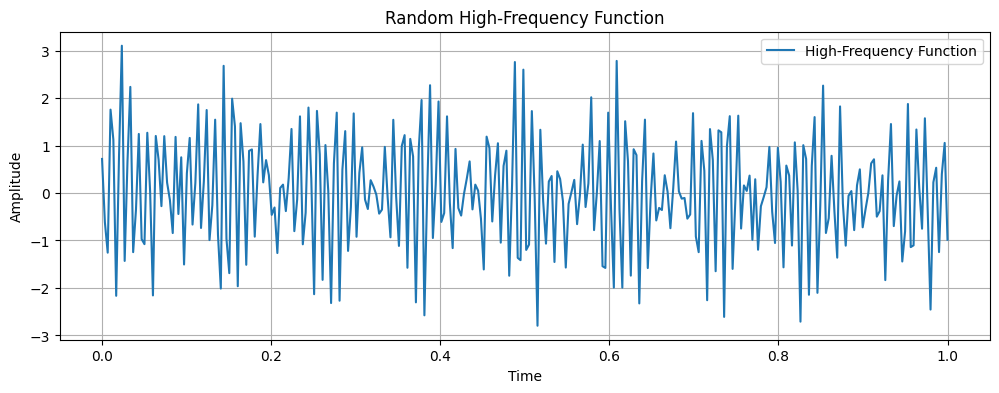

In [3]:
# Define the time values
n_points = 300
time = np.linspace(0, 1, n_points)  # points between 0 and 1

# Generate random frequencies for sine and cosine
freq_sin = np.random.uniform(50, 100)  # Random frequency for sine
freq_cos = np.random.uniform(50, 100)  # Random frequency for cosine

# Generate high-frequency functions
# Multiply by 2pi to convert from cycles/unit time to radians/unit time
high_freq_sin = np.sin(2 * np.pi * freq_sin * time)
high_freq_cos = np.cos(2 * np.pi * freq_cos * time)

# Introduce random noise
noise = np.random.normal(0, 0.5, time.shape)  # Generate random noise

# Combine the functions
high_freq_function = high_freq_sin + high_freq_cos + noise

# Plot the high-frequency function
plt.figure(figsize=(12, 4))
plt.plot(time, high_freq_function, label='High-Frequency Function')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Random High-Frequency Function')
plt.legend()
plt.grid(True)
plt.show()


We first try to "memorize" this signal with an MLP without using Fourier features.

In [4]:
import torch
import torch.nn as nn

In [5]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Create the model instance
model = MLP()

In [6]:
# Convert data to PyTorch tensors
inputs = torch.from_numpy(time).float().unsqueeze(1)
targets = torch.from_numpy(high_freq_function).float().unsqueeze(1)

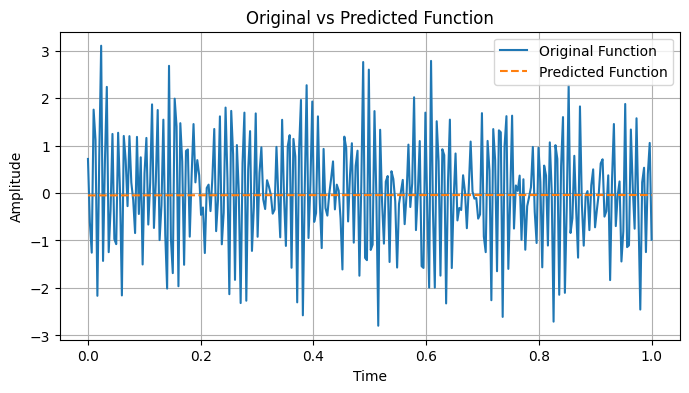

In [7]:
# Test untrained model
test_model(model, inputs)

The model performs poorly, even after 20,000 epochs.

Epoch [1000/20000], Loss: 1.3443
Epoch [2000/20000], Loss: 1.3331
Epoch [3000/20000], Loss: 1.3277
Epoch [4000/20000], Loss: 1.3146
Epoch [5000/20000], Loss: 1.3141
Epoch [6000/20000], Loss: 1.3001
Epoch [7000/20000], Loss: 1.2899
Epoch [8000/20000], Loss: 1.2793
Epoch [9000/20000], Loss: 1.2964
Epoch [10000/20000], Loss: 1.2652
Epoch [11000/20000], Loss: 1.2706
Epoch [12000/20000], Loss: 1.2564
Epoch [13000/20000], Loss: 1.2470
Epoch [14000/20000], Loss: 1.2447
Epoch [15000/20000], Loss: 1.2484
Epoch [16000/20000], Loss: 1.2405
Epoch [17000/20000], Loss: 1.2335
Epoch [18000/20000], Loss: 1.2192
Epoch [19000/20000], Loss: 1.2048
Epoch [20000/20000], Loss: 1.1955
Final Loss: 1.1955


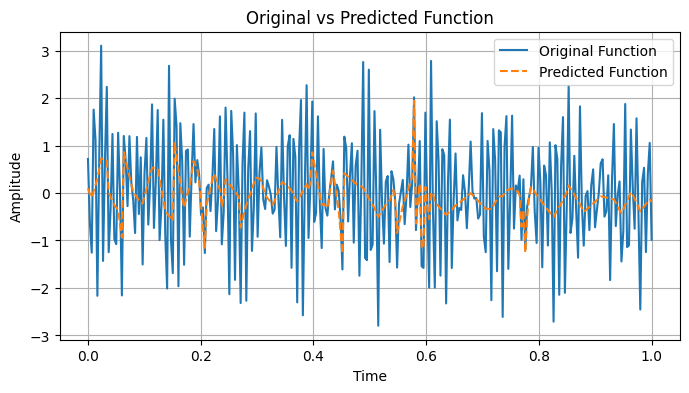

In [8]:
# Train the model
train_model(model, 20_000, inputs, targets)

# Plot the original function and the predicted function
test_model(model, inputs)

# Improvement using Fourier Feature Mapping
Mapping definitions are taken from the paper ["Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains"](https://arxiv.org/pdf/2006.10739.pdf)

Utiilty Functions for Input Projection

In [9]:
import math

In [10]:
def project_inputs(inputs, proj):
  mapped_inputs = []
  for x in inputs:
    encoding = proj(x)
    mapped_inputs.append(encoding)
  return np.array(mapped_inputs)

# Basic Mapping
(Wrapping the input around the unit circle)

In [11]:
# Depth of projection. Total input size = 2L +1
L = 4

In [12]:
# Basic Mapping
def basic_mapping(x, L):
  encoding = []
  for i in range(L):
    encoding.extend([np.sin(2**i * np.pi * x), np.cos(2**i * np.pi * x)])
  return encoding

# Project the time input array
mapped_time = project_inputs(time, lambda x: basic_mapping(x, L))

print(f'Input shape after basic mapping: {mapped_time.shape}')

Input shape after basic mapping: (300, 8)


With Basic Mapping we can get away with fewer layers!

In [13]:
# Input layer size dependent on projection
input_size = 2*L

# Define the MLP model, NOTE! we remove one of the layers
class BasicMappingMLP(nn.Module):
    def __init__(self):
        super(BasicMappingMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        # self.fc2 = nn.Linear(256, 256)    # Remove a layer
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Create the model instance
basic_mapping_MLP = BasicMappingMLP()

In [14]:
# Convert data to PyTorch tensors
inputs = torch.from_numpy(mapped_time).float()

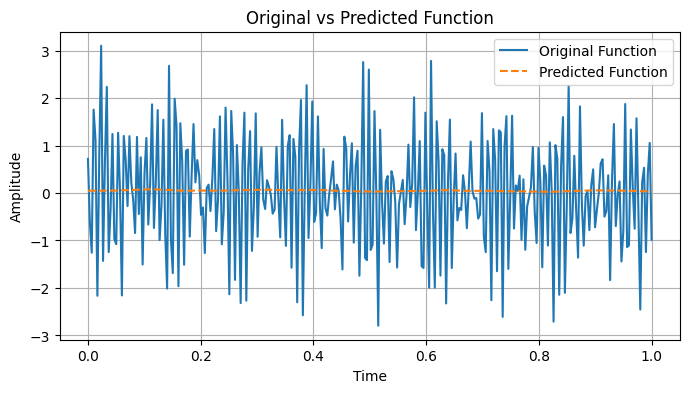

In [15]:
# Test the untrained model
test_model(basic_mapping_MLP, inputs)

Epoch [1000/20000], Loss: 0.8286
Epoch [2000/20000], Loss: 0.4962
Epoch [3000/20000], Loss: 0.3090
Epoch [4000/20000], Loss: 0.2790
Epoch [5000/20000], Loss: 0.2489
Epoch [6000/20000], Loss: 0.1088
Epoch [7000/20000], Loss: 0.1730
Epoch [8000/20000], Loss: 0.2098
Epoch [9000/20000], Loss: 0.0550
Epoch [10000/20000], Loss: 0.0599
Epoch [11000/20000], Loss: 0.0451
Epoch [12000/20000], Loss: 0.0418
Epoch [13000/20000], Loss: 0.0400
Epoch [14000/20000], Loss: 0.2229
Epoch [15000/20000], Loss: 0.0165
Epoch [16000/20000], Loss: 0.0986
Epoch [17000/20000], Loss: 0.0082
Epoch [18000/20000], Loss: 0.0070
Epoch [19000/20000], Loss: 0.0404
Epoch [20000/20000], Loss: 0.0108
Final Loss: 0.0108


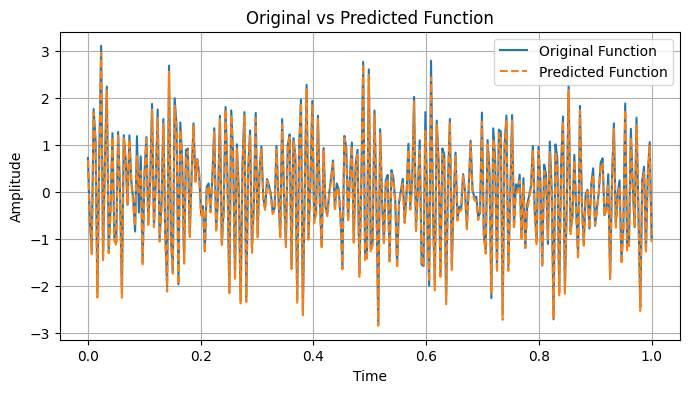

In [16]:
# Train model
train_model(basic_mapping_MLP, 20_000, inputs, targets)

# Test model
test_model(basic_mapping_MLP, inputs)

# Positional Encoding Mapping

This is a generalization of the positional encoding done in NeRF.

In [22]:
# Depth of projection. Total input size = 2L
L = 4

In [58]:
def positional_encoding_mapping(x, L, sigma):
  encoding = []
  for i in range(L):
    encoding.extend(
        [
            np.cos(2 * np.pi * sigma**(i/L) * x),
            np.sin(2 * np.pi * sigma**(i/L) * x)
        ])
  return encoding

# Project the time input array
mapped_time = project_inputs(time, lambda x: positional_encoding_mapping(x, L, sigma=30))

print(f'Input shape after positional encoding mapping: {mapped_time.shape}')

Input shape after positional encoding mapping: (300, 8)


As we'll see, with positional encoding, we can afford to reduce the size of the network. Here we remove two layers.

In [59]:
# Input layer size dependent on projection
input_size = 2*L

# Define the MLP model, NOTE! we remove two of the layers
class PositionalEncodingMLP(nn.Module):
    def __init__(self):
        super(PositionalEncodingMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(256, 256)
        # self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Create the model instance
positional_encoding_MLP = PositionalEncodingMLP()

# Convert data to PyTorch tensors
inputs = torch.from_numpy(mapped_time).float()

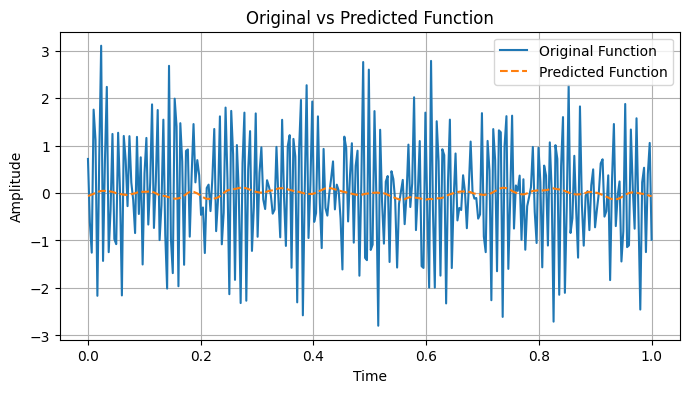

In [60]:
# Test the untrained model
test_model(positional_encoding_MLP, inputs)

We were able to reduce the number of epochs from 20,000 to 5,000 and still achieve similar performance to that of the basic mapping.

Epoch [1000/5000], Loss: 0.0431
Epoch [2000/5000], Loss: 0.0067
Epoch [3000/5000], Loss: 0.0039
Epoch [4000/5000], Loss: 0.0003
Epoch [5000/5000], Loss: 0.0167
Final Loss: 0.0167


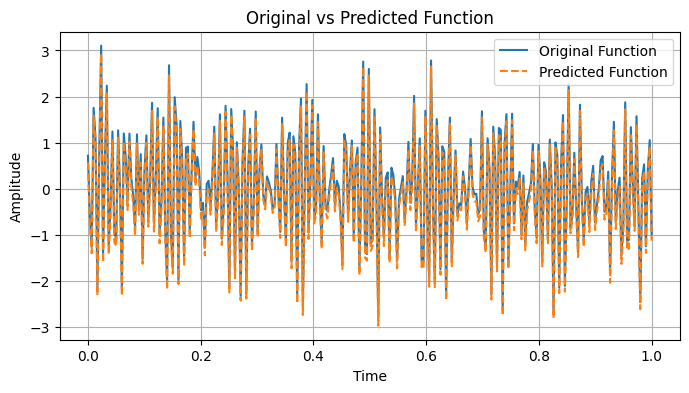

In [61]:
# Train model
train_model(positional_encoding_MLP, 5_000, inputs, targets)

# Test model
test_model(positional_encoding_MLP, inputs)

## Gaussian Fourier Feature Mapping

In [17]:
# Depth of projection. Total input size = 2L
L = 4

In [18]:
def guassian_mapping(x, L, sigma):
  encoding = []
  b = np.random.normal(0, sigma, L)
  for i in range(L):
    encoding.extend(
        [
            np.cos(2 * np.pi * b[i] * x),
            np.sin(2 * np.pi * b[i] * x)
        ])
  return encoding

# Project the time input array
mapped_time = project_inputs(time, lambda x: guassian_mapping(x, L, sigma=10))

print(f'Input shape after guassian mapping: {mapped_time.shape}')

Input shape after guassian mapping: (300, 8)


Like with positional encoding, we can remove two layers from the original network.

In [19]:
# Input layer size dependent on projection
input_size = 2*L

# Define the MLP model, NOTE! we remove two of the layers
class GaussianMappingMLP(nn.Module):
    def __init__(self):
        super(GaussianMappingMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(256, 256)
        # self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Create the model instance
guassin_mapping_MLP = GaussianMappingMLP()

# Convert data to PyTorch tensors
inputs = torch.from_numpy(mapped_time).float()

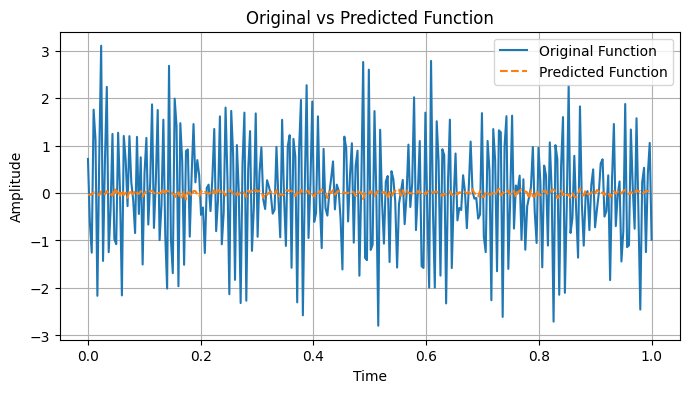

In [20]:
# Test the untrained model
test_model(guassin_mapping_MLP, inputs)

Not only can we get away with a smaller network, but we can also reduce the number of epochs from 20,000 (basic mapping) and 5,000 (positional encoding) to 300

Final Loss: 0.0094


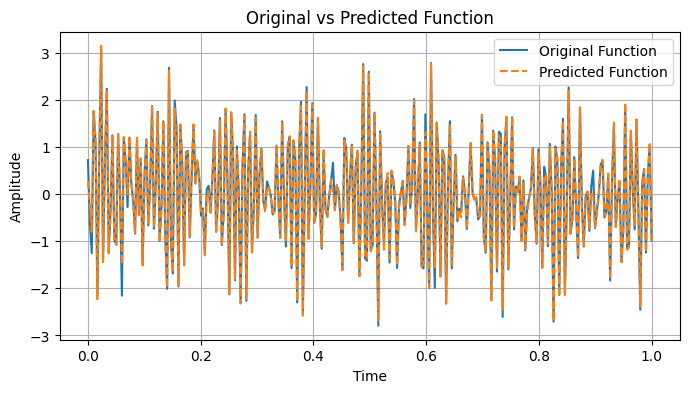

In [21]:
# Train model
train_model(guassin_mapping_MLP, 300, inputs, targets)

# Test model
test_model(guassin_mapping_MLP, inputs)